### Import Libraries

In [86]:
import yfinance as yf
import numpy as np
import pandas as pd
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
emiten = 'ELSA'

### LANGKAH 1: Download Data & Rekayasa Fitur

In [87]:
print("\n📥 Downloading stock data...")
data_raw = yf.download(emiten+'.JK', period="5y",interval="1d", progress=False)
data = data_raw.copy()

if isinstance(data.columns, pd.MultiIndex):
    data.columns = [col[0] for col in data.columns]

print("✅ Data downloaded successfully")
print(f"   Shape: {data.shape}")


📥 Downloading stock data...
✅ Data downloaded successfully
   Shape: (1208, 5)


In [88]:
# Tambahkan Fitur Teknikal
print("\n🔧 Creating technical indicators...")
data['Prev Close'] = data['Close'].shift(1)
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()

# RSI
delta = data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
gain_avg = gain.rolling(window=14).mean()
loss_avg = loss.rolling(window=14).mean()
rs = gain_avg / (loss_avg + 1e-8)
data['RSI'] = 100 - (100 / (1 + rs))

# MACD
data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA12'] - data['EMA26']
data['Signal Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Bollinger Bands
data['BB_Upper'] = data['Close'].rolling(window=20).mean() + 2*data['Close'].rolling(window=20).std()
data['BB_Lower'] = data['Close'].rolling(window=20).mean() - 2*data['Close'].rolling(window=20).std()

# ATR
high_low = data['High'] - data['Low']
high_close = abs(data['High'] - data['Close'].shift(1))
low_close = abs(data['Low'] - data['Close'].shift(1))
true_range = pd.concat([high_low, high_close, low_close], axis=1)
data['ATR'] = true_range.max(axis=1).rolling(window=14).mean()

# Stochastic
data['Stochastic_K'] = 100 * (data['Close'] - data['Low'].rolling(window=14).min()) / \
                       (data['High'].rolling(window=14).max() - data['Low'].rolling(window=14).min())
data['Stochastic_D'] = data['Stochastic_K'].rolling(window=3).mean()

# CCI
data['CCI'] = (data['Close'] - data['Close'].rolling(window=20).mean()) / \
              (0.015 * data['Close'].rolling(window=20).std())

# OBV
data['OBV'] = np.where(data['Close'] > data['Close'].shift(1), data['Volume'],
                       np.where(data['Close'] < data['Close'].shift(1), -data['Volume'], 0))
data['OBV'] = data['OBV'].cumsum()

# Lag features
for i in range(1, 6):
    data[f'Lag{i}'] = data['Close'].shift(i)

data = data.dropna()
data = data.reset_index()

print(f"✅ Technical indicators created")
print(f"   Final shape: {data.shape}")


🔧 Creating technical indicators...
✅ Technical indicators created
   Final shape: (1159, 26)


### LANGKAH 2: Persiapan Data untuk Prophet

In [89]:
print("\n📊 Preparing data for Prophet...")
df_prophet = data.rename(columns={'Date': 'ds', 'Close': 'y'})

regressors = [
    'Prev Close', 'MA20', 'MA50', 'MACD', 'Signal Line',
    'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'RSI',
    'BB_Upper', 'BB_Lower', 'ATR', 'Stochastic_K', 'Stochastic_D', 'CCI', 'OBV', 'Volume'
]

# Split data
train_size = int(len(df_prophet) * 0.8)
train_df = df_prophet[:train_size]
test_df = df_prophet[train_size:]

print(f"✅ Data split completed")
print(f"   Training samples: {len(train_df)}")
print(f"   Testing samples: {len(test_df)}")
print(f"   Number of features: {len(regressors)}")


📊 Preparing data for Prophet...
✅ Data split completed
   Training samples: 927
   Testing samples: 232
   Number of features: 19


In [90]:
print("\n⚖️  Normalizing technical features...")

# Kita gunakan .copy() agar tidak muncul SettingWithCopyWarning
train_df = df_prophet[:train_size].copy()
test_df = df_prophet[train_size:].copy()

scaler = MinMaxScaler()

# Hanya normalisasi kolom FITUR (regressors), JANGAN normalisasi 'y' (Target)
# Fit pada training, transform pada training & testing
train_df[regressors] = scaler.fit_transform(train_df[regressors])
test_df[regressors] = scaler.transform(test_df[regressors])

print("✅ Features scaled to 0-1 range")


⚖️  Normalizing technical features...
✅ Features scaled to 0-1 range


### LANGKAH 3: Membuat & Melatih Model Prophet

In [91]:
print("\n🤖 Training Prophet model...")
model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    n_changepoints=25
)

for regressor in regressors:
    model_prophet.add_regressor(regressor, prior_scale=10.0)

model_prophet.fit(train_df)
print("✅ Prophet model trained successfully")

21:19:03 - cmdstanpy - INFO - Chain [1] start processing



🤖 Training Prophet model...


21:19:04 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet model trained successfully


### LANGKAH 4: Persiapan Data untuk XGBoost

In [92]:
print("\n🔧 Preparing data for XGBoost...")

feature_cols = regressors.copy()
available_features = [col for col in feature_cols if col in train_df.columns]

if len(available_features) < len(feature_cols):
    missing = set(feature_cols) - set(available_features)
    print(f"⚠️ Warning: Some features not found: {missing}")
    feature_cols = available_features

print(f"✅ Using {len(feature_cols)} features for XGBoost")

# Extract features dan target
X_train = train_df[feature_cols].values
y_train = train_df['y'].values

X_test = test_df[feature_cols].values
y_test = test_df['y'].values

# Handle missing values
if np.any(np.isnan(X_train)) or np.any(np.isnan(X_test)):
    print("⚠️ Found NaN values, filling with median...")
    imputer = SimpleImputer(strategy='median')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

print(f"   X_train shape: {X_train.shape}")
print(f"   X_test shape: {X_test.shape}")


🔧 Preparing data for XGBoost...
✅ Using 19 features for XGBoost
   X_train shape: (927, 19)
   X_test shape: (232, 19)


### LANGKAH 5: Dapatkan Prediksi Prophet & Hitung Residual

In [93]:
print("\n🔮 Getting Prophet predictions...")

# Prediksi Prophet pada data training
forecast_train = model_prophet.predict(train_df)
prophet_pred_train = forecast_train['yhat'].values

# Prediksi Prophet pada data test
future = test_df.drop(columns='y')
forecast = model_prophet.predict(future)
prophet_pred_test = forecast['yhat'].values

print(f"✅ Prophet predictions obtained")
print(f"   Train predictions: {len(prophet_pred_train)}")
print(f"   Test predictions: {len(prophet_pred_test)}")

# Hitung Residual (error Prophet)
print("\n📊 Calculating Prophet residuals...")
train_residuals = y_train - prophet_pred_train

print(f"✅ Residuals calculated")
print(f"   Mean residual: {np.mean(train_residuals):.4f}")
print(f"   Std residual: {np.std(train_residuals):.4f}")


🔮 Getting Prophet predictions...
✅ Prophet predictions obtained
   Train predictions: 927
   Test predictions: 232

📊 Calculating Prophet residuals...
✅ Residuals calculated
   Mean residual: -0.0001
   Std residual: 1.5209


### LANGKAH 6: Latih XGBoost untuk Memprediksi Residual

In [94]:
print("\n🤖 Training XGBoost to learn Prophet's errors...")
print("   This may take a few minutes...")

xgb_model = xgb.XGBRegressor(
    n_estimators=50,         # Turunkan drastis (cegah overfitting noise)
    learning_rate=0.01,      # Sangat lambat
    max_depth=2,             # Sangat dangkal (hanya pola besar)
    subsample=0.5,
    colsample_bytree=0.5,
    min_child_weight=20,     # SANGAT TINGGI (Abaikan fluktuasi kecil)
    gamma=1.0,               # SANGAT TINGGI (Pruning agresif)
    reg_alpha=0.1,
    reg_lambda=50.0,         # Regularisasi KUAT (supaya model 'cari aman')
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

xgb_model.fit(
    X_train,
    train_residuals,
    eval_set=[(X_train, train_residuals)],
    verbose=False
)

print("✅ XGBoost training completed!")


🤖 Training XGBoost to learn Prophet's errors...
   This may take a few minutes...
✅ XGBoost training completed!


### LANGKAH 7: Buat Prediksi Hybrid

In [95]:
print("\n🎯 Making hybrid predictions...")

# Prediksi residual dengan XGBoost
xgb_pred_residuals = xgb_model.predict(X_test)

# Gabungkan: Hybrid = Prophet + XGBoost Correction
hybrid_prediction = prophet_pred_test + xgb_pred_residuals

print("✅ Hybrid predictions completed!")


🎯 Making hybrid predictions...
✅ Hybrid predictions completed!


In [96]:
print(hybrid_prediction)

[410.07655133 405.82935263 404.52481133 409.61152463 405.64133122
 401.37100825 399.8795042  396.66987965 397.19760254 397.94284672
 398.42013492 412.65391895 421.18323946 412.19157267 405.79984004
 395.4748813  393.18635077 385.05576772 383.41763186 388.60584668
 391.76416209 393.25902304 393.26468825 397.34495826 394.18587463
 392.44775259 394.52232944 389.26017499 382.89681953 371.32351349
 361.71116455 357.28916107 368.27869732 359.83621409 356.37540868
 357.39297541 359.29694278 359.03046168 357.93884859 361.68291353
 362.38334377 361.29573003 366.27011999 357.78835054 354.76536069
 350.84727301 360.65306989 353.74118192 360.04776738 376.66190968
 385.85706845 348.87836057 358.9583488  374.31410517 374.76390398
 387.8361506  383.56979208 382.1153964  386.91669088 393.2962186
 398.305702   394.53460218 398.21392031 402.99816877 410.96228208
 421.6007036  422.67625247 426.77475612 422.54970946 428.15474575
 430.23484276 436.05310177 427.59917188 438.3486427  443.6573001
 445.5468625

### LANGKAH 8: Evaluasi dan Perbandingan

In [97]:
print("\n📈 Evaluating model performance...")

# Metrik Prophet Only
mae_prophet = mean_absolute_error(y_test, prophet_pred_test)
rmse_prophet = np.sqrt(mean_squared_error(y_test, prophet_pred_test))
r2_prophet = r2_score(y_test, prophet_pred_test)
mape_prophet = np.mean(np.abs((y_test - prophet_pred_test) / y_test)) * 100

# Metrik Hybrid Model
mae_hybrid = mean_absolute_error(y_test, hybrid_prediction)
rmse_hybrid = np.sqrt(mean_squared_error(y_test, hybrid_prediction))
r2_hybrid = r2_score(y_test, hybrid_prediction)
mape_hybrid = np.mean(np.abs((y_test - hybrid_prediction) / y_test)) * 100

# --- PERHITUNGAN DA SESUAI RUMUS DI GAMBAR ---
# T adalah jumlah total interval perubahan (n-1)
T = len(y_test) - 1

# 1. Hitung perubahan arah aktual dan prediksi
actual_diff = np.diff(y_test)
prophet_diff = np.diff(prophet_pred_test)
hybrid_diff = np.diff(hybrid_prediction)

# 2. Definisikan ai (Indikator: 1 jika arah sama, 0 jika berbeda)
# Sesuai rumus: ai = 1 jika sign perubahan sama
ai_prophet = (np.sign(actual_diff) == np.sign(prophet_diff)).astype(int)
ai_hybrid = (np.sign(actual_diff) == np.sign(hybrid_diff)).astype(int)

# 3. Hitung DA = (1/T) * Sum(ai) * 100%
da_prophet = (1/T) * np.sum(ai_prophet) * 100
da_hybrid = (1/T) * np.sum(ai_hybrid) * 100
# ---------------------------------------------

# Hitung improvement
rmse_improvement = ((rmse_prophet - rmse_hybrid) / rmse_prophet) * 100
mae_improvement = ((mae_prophet - mae_hybrid) / mae_prophet) * 100
r2_improvement = ((r2_hybrid - r2_prophet) / abs(r2_prophet)) * 100
da_improvement = da_hybrid - da_prophet

print("\n" + "="*70)
print("📊 HYBRID MODEL - EVALUATION METRICS")
print("="*70)
print("\n🔵 PROPHET ONLY:")
print(f"   RMSE  : {rmse_prophet:.4f}")
print(f"   MAE   : {mae_prophet:.4f}")
print(f"   R²    : {r2_prophet:.4f}")
print(f"   MAPE  : {mape_prophet:.2f}%")
print(f"   DA    : {da_prophet:.2f}%")

print("\n🟢 HYBRID (PROPHET + XGBOOST):")
print(f"   RMSE  : {rmse_hybrid:.4f}")
print(f"   MAE   : {mae_hybrid:.4f}")
print(f"   R²    : {r2_hybrid:.4f}")
print(f"   MAPE  : {mape_hybrid:.2f}%")
print(f"   DA    : {da_hybrid:.2f}%")

print("\n📈 IMPROVEMENT:")
print(f"   RMSE  : {rmse_improvement:+.2f}%")
print(f"   MAE   : {mae_improvement:+.2f}%")
print(f"   R²    : {r2_improvement:+.2f}%")
print(f"   DA    : {da_improvement:+.2f}%")

if rmse_improvement > 0:
    print(f"\n✨ Hybrid model is {rmse_improvement:.2f}% better than Prophet!")
else:
    print(f"\n⚠️ Prophet alone performs better by {abs(rmse_improvement):.2f}%")

print("="*70)


📈 Evaluating model performance...

📊 HYBRID MODEL - EVALUATION METRICS

🔵 PROPHET ONLY:
   RMSE  : 4.7109
   MAE   : 3.9005
   R²    : 0.9920
   MAPE  : 0.83%
   DA    : 81.39%

🟢 HYBRID (PROPHET + XGBOOST):
   RMSE  : 4.7216
   MAE   : 3.9109
   R²    : 0.9920
   MAPE  : 0.83%
   DA    : 81.39%

📈 IMPROVEMENT:
   RMSE  : -0.23%
   MAE   : -0.27%
   R²    : -0.00%
   DA    : +0.00%

⚠️ Prophet alone performs better by 0.23%


### LANGKAH 9: Visualisasi Komprehensif


📊 Creating visualizations...
✅ Visualization saved as 'hybrid_results.png'


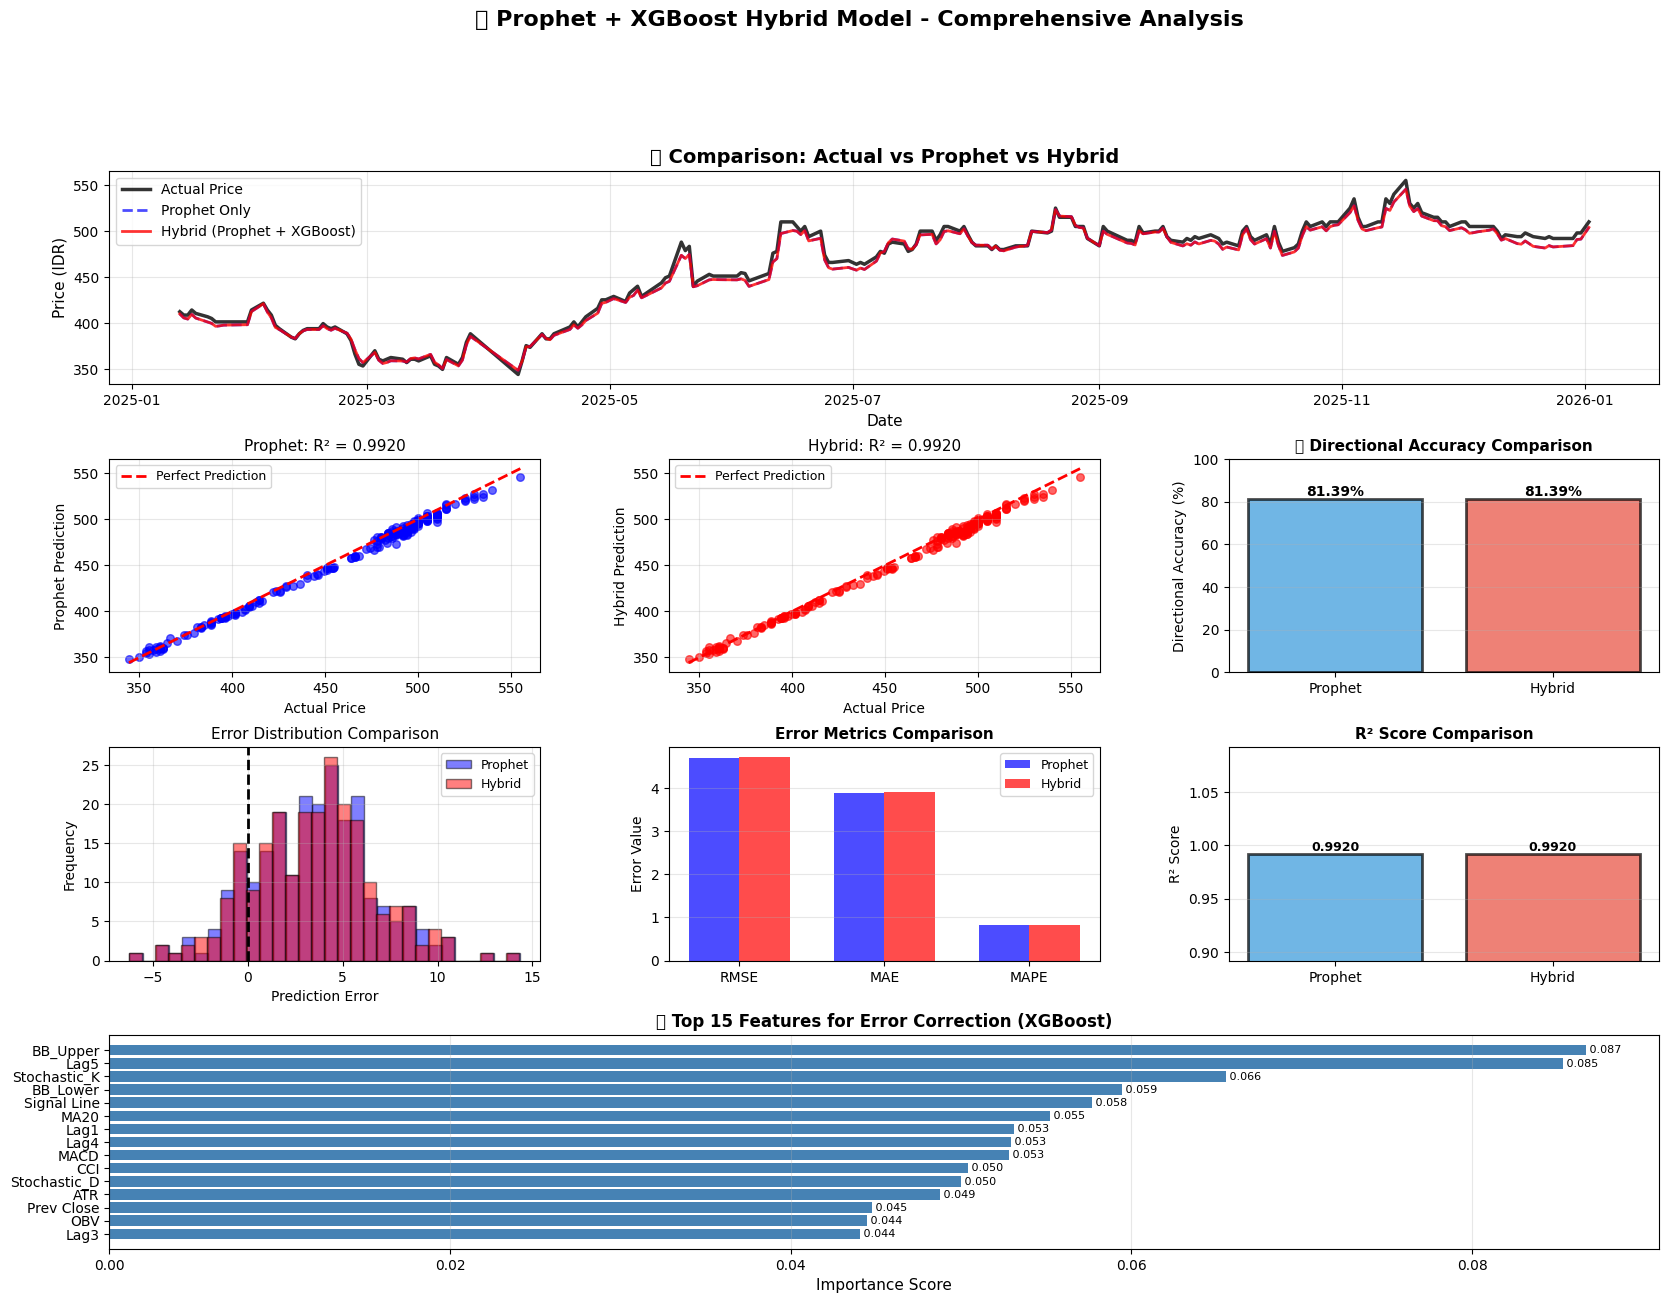

In [98]:
print("\n📊 Creating visualizations...")

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# Plot 1: Time Series Comparison
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(test_df['ds'], y_test, label='Actual Price', color='black', linewidth=2.5, alpha=0.8)
ax1.plot(test_df['ds'], prophet_pred_test, label='Prophet Only', color='blue',
         linestyle='--', linewidth=2, alpha=0.7)
ax1.plot(test_df['ds'], hybrid_prediction, label='Hybrid (Prophet + XGBoost)',
         color='red', linewidth=2, alpha=0.8)
ax1.set_title('📈 Comparison: Actual vs Prophet vs Hybrid', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Price (IDR)', fontsize=11)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Prophet Scatter
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(y_test, prophet_pred_test, alpha=0.6, color='blue', s=30)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Price', fontsize=10)
ax2.set_ylabel('Prophet Prediction', fontsize=10)
ax2.set_title(f'Prophet: R² = {r2_prophet:.4f}', fontsize=11)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Hybrid Scatter
ax3 = fig.add_subplot(gs[1, 1])
ax3.scatter(y_test, hybrid_prediction, alpha=0.6, color='red', s=30)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Price', fontsize=10)
ax3.set_ylabel('Hybrid Prediction', fontsize=10)
ax3.set_title(f'Hybrid: R² = {r2_hybrid:.4f}', fontsize=11)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Plot 4: Directional Accuracy Comparison
ax4 = fig.add_subplot(gs[1, 2])
models = ['Prophet', 'Hybrid']
da_values = [da_prophet, da_hybrid]
colors_da = ['#3498db', '#e74c3c']
bars = ax4.bar(models, da_values, color=colors_da, alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_ylabel('Directional Accuracy (%)', fontsize=10)
ax4.set_title('📊 Directional Accuracy Comparison', fontsize=11, fontweight='bold')
ax4.set_ylim([0, 100])
ax4.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars, da_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 5: Residuals Comparison
ax5 = fig.add_subplot(gs[2, 0])
prophet_residuals = y_test - prophet_pred_test
hybrid_residuals = y_test - hybrid_prediction
ax5.hist(prophet_residuals, bins=30, alpha=0.5, color='blue', label='Prophet', edgecolor='black')
ax5.hist(hybrid_residuals, bins=30, alpha=0.5, color='red', label='Hybrid', edgecolor='black')
ax5.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax5.set_xlabel('Prediction Error', fontsize=10)
ax5.set_ylabel('Frequency', fontsize=10)
ax5.set_title('Error Distribution Comparison', fontsize=11)
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)

# Plot 6: Metrics Comparison
ax6 = fig.add_subplot(gs[2, 1])
metrics = ['RMSE', 'MAE', 'MAPE']
prophet_metrics = [rmse_prophet, mae_prophet, mape_prophet]
hybrid_metrics = [rmse_hybrid, mae_hybrid, mape_hybrid]
x = np.arange(len(metrics))
width = 0.35
ax6.bar(x - width/2, prophet_metrics, width, label='Prophet', color='blue', alpha=0.7)
ax6.bar(x + width/2, hybrid_metrics, width, label='Hybrid', color='red', alpha=0.7)
ax6.set_ylabel('Error Value', fontsize=10)
ax6.set_title('Error Metrics Comparison', fontsize=11, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(metrics)
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3, axis='y')

# Plot 7: R² Comparison
ax7 = fig.add_subplot(gs[2, 2])
r2_values = [r2_prophet, r2_hybrid]
bars_r2 = ax7.bar(models, r2_values, color=colors_da, alpha=0.7, edgecolor='black', linewidth=2)
ax7.set_ylabel('R² Score', fontsize=10)
ax7.set_title('R² Score Comparison', fontsize=11, fontweight='bold')
ax7.set_ylim([min(r2_values) - 0.1, max(r2_values) + 0.1])
ax7.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars_r2, r2_values):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 8: Feature Importance (Top 15)
ax8 = fig.add_subplot(gs[3, :])
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

bars = ax8.barh(range(len(importance_df)), importance_df['Importance'], color='steelblue')
ax8.set_yticks(range(len(importance_df)))
ax8.set_yticklabels(importance_df['Feature'])
ax8.set_xlabel('Importance Score', fontsize=11)
ax8.set_title('🔍 Top 15 Features for Error Correction (XGBoost)', fontsize=12, fontweight='bold')
ax8.invert_yaxis()
ax8.grid(True, alpha=0.3, axis='x')

for i, (bar, value) in enumerate(zip(bars, importance_df['Importance'])):
    ax8.text(value, i, f' {value:.3f}', va='center', fontsize=8)

plt.suptitle('🚀 Prophet + XGBoost Hybrid Model - Comprehensive Analysis',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
# plt.savefig('hybrid_results.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved as 'hybrid_results.png'")
plt.show()

### LANGKAH 10: Detailed Insights

In [99]:
print("\n💡 KEY INSIGHTS:")
print(f"   - Prophet MAPE: {mape_prophet:.2f}%")
print(f"   - Hybrid MAPE: {mape_hybrid:.2f}%")
print(f"   - Accuracy Improvement: {mape_prophet - mape_hybrid:.2f}%")

print(f"\n📊 DIRECTIONAL ACCURACY (DA) - Most Important for Trading:")
print(f"   - Prophet DA: {da_prophet:.2f}%")
print(f"   - Hybrid DA: {da_hybrid:.2f}%")
print(f"   - DA Improvement: {da_improvement:+.2f}%")

if da_improvement > 0:
    print(f"   ✅ Hybrid model correctly predicts direction {da_improvement:.2f}% better!")
else:
    print(f"   ⚠️ Prophet predicts direction {abs(da_improvement):.2f}% better")

prophet_errors = np.abs(y_test - prophet_pred_test)
hybrid_errors = np.abs(y_test - hybrid_prediction)
print(f"\n   - Prophet Average Error: {np.mean(prophet_errors):.2f} IDR")
print(f"   - Hybrid Average Error: {np.mean(hybrid_errors):.2f} IDR")

print(f"\n   - Top 3 Most Important Features for Error Correction:")
for i, row in importance_df.head(3).iterrows():
    print(f"     {i+1}. {row['Feature']}: {row['Importance']:.4f}")

print("\n🎉 Prophet + XGBoost Hybrid Model Analysis Completed!")
print("="*70)


💡 KEY INSIGHTS:
   - Prophet MAPE: 0.83%
   - Hybrid MAPE: 0.83%
   - Accuracy Improvement: -0.00%

📊 DIRECTIONAL ACCURACY (DA) - Most Important for Trading:
   - Prophet DA: 81.39%
   - Hybrid DA: 81.39%
   - DA Improvement: +0.00%
   ⚠️ Prophet predicts direction 0.00% better

   - Prophet Average Error: 3.90 IDR
   - Hybrid Average Error: 3.91 IDR

   - Top 3 Most Important Features for Error Correction:
     12. BB_Upper: 0.0867
     10. Lag5: 0.0853
     15. Stochastic_K: 0.0656

🎉 Prophet + XGBoost Hybrid Model Analysis Completed!


In [100]:
# === Export trained models as Streamlit-ready artifacts ===
from pathlib import Path
import joblib

# Ensure output directory exists
out_dir = Path('../../models').resolve()
out_dir.mkdir(parents=True, exist_ok=True)

# Collect metrics if available
metrics_prophet = {
    'rmse': float(rmse_prophet) if 'rmse_prophet' in globals() else None,
    'mae': float(mae_prophet) if 'mae_prophet' in globals() else None,
    'mape': float(mape_prophet) if 'mape_prophet' in globals() else None,
    'r2': float(r2_prophet) if 'r2_prophet' in globals() else None,
    'directional_accuracy': float(da_prophet) if 'da_prophet' in globals() else None,
}
metrics_hybrid = {
    'rmse': float(rmse_hybrid) if 'rmse_hybrid' in globals() else None,
    'mae': float(mae_hybrid) if 'mae_hybrid' in globals() else None,
    'mape': float(mape_hybrid) if 'mape_hybrid' in globals() else None,
    'r2': float(r2_hybrid) if 'r2_hybrid' in globals() else None,
    'directional_accuracy': float(da_hybrid) if 'da_hybrid' in globals() else None,
}

# Prophet-only artifact
prophet_artifact = {
    'model_type': 'prophet',
    'model': model_prophet,
    'feature_columns': feature_cols if 'feature_cols' in globals() else None,
    'metrics': metrics_prophet,
}
prophet_path = out_dir / 'prophet.joblib'
# joblib.dump(prophet_artifact, str(prophet_path))

# Hybrid artifact (Prophet + XGBoost residual correction)
# NOTE: Streamlit inference will carry-forward latest feature values for future periods.
hybrid_artifact = {
    'model_type': 'hybrid',
    'prophet': model_prophet,
    'xgb': xgb_model,
    'feature_columns': feature_cols if 'feature_cols' in globals() else [],
    'metrics': metrics_hybrid,
}
hybrid_path = out_dir / (emiten + '_hybrid.joblib')
joblib.dump(hybrid_artifact, str(hybrid_path))

print(f"\n✅ Saved artifacts:\n - {prophet_path}\n - {hybrid_path}")

# Optional (recommended) Prophet JSON serialization for cross-version portability:
# from prophet.serialize import model_to_json
# with open(out_dir / 'prophet.json', 'w') as f:
#     f.write(model_to_json(model_prophet))



✅ Saved artifacts:
 - C:\Users\PC\JD\__code\python\skripsi\models\prophet.joblib
 - C:\Users\PC\JD\__code\python\skripsi\models\ELSA_hybrid.joblib


In [101]:
# === Re-export artifacts including the fitted scaler ===
from pathlib import Path
import joblib

out_dir = Path('../../models').resolve()
out_dir.mkdir(parents=True, exist_ok=True)

# prophet_artifact = {
#     'model_type': 'prophet',
#     'model': model_prophet,
#     'feature_columns': feature_cols if 'feature_cols' in globals() else None,
#     'scaler': scaler if 'scaler' in globals() else None,
#     'metrics': {
#         'rmse': float(rmse_prophet) if 'rmse_prophet' in globals() else None,
#         'mae': float(mae_prophet) if 'mae_prophet' in globals() else None,
#         'mape': float(mape_prophet) if 'mape_prophet' in globals() else None,
#         'r2': float(r2_prophet) if 'r2_prophet' in globals() else None,
#         'directional_accuracy': float(da_prophet) if 'da_prophet' in globals() else None,
#     },
# }
# joblib.dump(prophet_artifact, str(out_dir / 'prophet.joblib'))

hybrid_artifact = {
    'model_type': 'hybrid',
    'prophet': model_prophet,
    'xgb': xgb_model,
    'feature_columns': feature_cols if 'feature_cols' in globals() else [],
    'scaler': scaler if 'scaler' in globals() else None,
    'metrics': {
        'rmse': float(rmse_hybrid) if 'rmse_hybrid' in globals() else None,
        'mae': float(mae_hybrid) if 'mae_hybrid' in globals() else None,
        'mape': float(mape_hybrid) if 'mape_hybrid' in globals() else None,
        'r2': float(r2_hybrid) if 'r2_hybrid' in globals() else None,
        'directional_accuracy': float(da_hybrid) if 'da_hybrid' in globals() else None,
    },
}
joblib.dump(hybrid_artifact, str(out_dir / (emiten + '_hybrid.joblib')))

print("✅ Re-saved artifacts with scaler:", out_dir)


✅ Re-saved artifacts with scaler: C:\Users\PC\JD\__code\python\skripsi\models


# Export Artifacts with Scaler and Feature Columns
This section saves both Prophet and Hybrid (Prophet + XGBoost) artifacts including the fitted `MinMaxScaler` and the list of regressor `feature_columns`. Run these cells after training has completed.

In [102]:
# Export Prophet/Hybrid artifacts including scaler and feature columns
from pathlib import Path
import joblib
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

# Auto-detect trained objects from this notebook session
prophet_model = next((v for v in globals().values() if isinstance(v, Prophet)), None)
xgb_model = next((v for v in globals().values() if hasattr(v, 'predict') and v.__class__.__name__.lower().startswith('xgb')), None)
scaler = next((v for v in globals().values() if isinstance(v, MinMaxScaler)), None)

# Try to infer feature columns from any DataFrame used in training
feature_cols = None
candidate_dfs = [(name, v) for name, v in globals().items() if isinstance(v, pd.DataFrame)]
known_indicators = {'Prev Close','MA20','MA50','MACD','Signal Line','Lag1','Lag2','Lag3','Lag4','Lag5','RSI','BB_upper','BB_lower','ATR','Stochastic_K','Stochastic_D','CCI','OBV','High','Low','Volume'}
for name, d in candidate_dfs:
    if hasattr(d, 'columns'):
        cols = list(d.columns)
        if 'ds' in cols and ('y' in cols or 'Close' in cols):
            feats = [c for c in cols if c not in ['ds','y','Close']]
            if len(set(feats) & known_indicators) >= 5:
                feature_cols = feats
                break

# Fallback: pick columns from the first DataFrame excluding ds/y/Close
if feature_cols is None and candidate_dfs:
    d = candidate_dfs[0][1]
    feature_cols = [c for c in d.columns if c not in ['ds','y','Close']]

# Try to pick metrics dicts if present
prophet_metrics = next((v for v in globals().values() if isinstance(v, dict) and {'rmse','mae','r2'} <= set(v.keys())), None)
hybrid_metrics = next((v for v in globals().values() if isinstance(v, dict) and {'rmse','mae','r2'} <= set(v.keys())), None)

print('Found objects:', {
    'prophet_model': prophet_model is not None,
    'xgb_model': xgb_model is not None,
    'scaler': scaler is not None,
    'feature_cols': len(feature_cols) if feature_cols else 0,
})

if scaler is None:
    raise RuntimeError('No fitted MinMaxScaler found. Ensure you kept the scaler fitted on training regressors.')
if prophet_model is None:
    raise RuntimeError('No Prophet model instance found. Please run training before export.')
if feature_cols is None or len(feature_cols) == 0:
    raise RuntimeError('Could not determine feature_columns from training data.')

export_dir = Path('artifacts/models')
export_dir.mkdir(parents=True, exist_ok=True)

# Save Prophet
# joblib.dump({
#     'model_type': 'prophet',
#     'prophet': prophet_model,
#     'scaler': scaler,
#     'feature_columns': feature_cols,
#     'metrics': prophet_metrics,
# }, export_dir / 'prophet.joblib')

# Save Hybrid when XGBoost is available
if xgb_model is not None:
    joblib.dump({
        'model_type': 'hybrid',
        'prophet': prophet_model,
        'xgb': xgb_model,
        'scaler': scaler,
        'feature_columns': feature_cols,
        'metrics': hybrid_metrics,
    }, export_dir / (emiten+'_hybrid.joblib'))
    print('Saved hybrid.joblib with scaler and feature_columns')
else:
    print('No XGBoost model found; saved only prophet.joblib')

Found objects: {'prophet_model': True, 'xgb_model': True, 'scaler': True, 'feature_cols': 24}
Saved hybrid.joblib with scaler and feature_columns
